# Reinforcement Learning and Value Iteration

Reinforcement Learning (RL) studies how an agent learns to make sequential decisions in an environment to maximize long-term reward. Unlike supervised learning where we have labeled correct answers, in RL the agent only receives rewards or penalties and must learn through trial and error which actions lead to good outcomes.

## The Gridworld Problem

In this notebook, we'll explore a simple 5×5 gridworld where:
- An agent can move in 4 directions: ↑, ↓, ←, →
- Hitting a wall: agent stays in place, receives reward of −1
- Two special teleporter locations:
  - **A** (top row, 2nd column) → **A'** (bottom row, 2nd column): reward +10
  - **B** (top row, 4th column) → **B'** (middle row, 4th column): reward +5
- Discount factor $\gamma$ = 0.9 (future rewards are worth 90% as much as immediate rewards)

The goal is to find the best strategy (policy) for navigating this world.

## Markov Decision Process (MDP)

We formalize this as an MDP with:

- **States** ($S$): All possible positions in the grid (25 states)
- **Actions** ($A$): Four movement directions available in each state
- **Transition dynamics** ($p$): Probability of reaching state $s'$ from state $s$ via action $a$ (deterministic here)
- **Reward** ($R$): Immediate feedback received after each transition
- **Discount** ($\gamma \in [0,1)$): Balances immediate vs. future rewards

The **value function** $v_{\pi}(s)$ represents the expected total discounted reward starting from state $s$ and following policy $\pi$.

## The Bellman Equation

For any fixed policy $\pi$, the value function satisfies the **Bellman Equation**:

$$ v_{\pi}(s) = \sum_a \pi(a|s) \sum_{s'} p(s'|s,a) [ r(s,a,s') + \gamma v_{\pi}(s') ] $$

This says: *The value of a state equals the expected immediate reward plus the discounted value of the next state, averaged over the actions the policy might take.*


## Evaluating value function of a policy

Before finding the optimal policy, let's first understand how to evaluate any fixed policy. We'll start with the simplest policy: a **uniform random policy** that chooses each action with equal probability (25% each).

This will help us understand how the Bellman equation works in practice.

### Solving Explicitly as a Linear System

For a given policy, the Bellman equation becomes a **linear system of equations**. Let's see this explicitly for our 5×5 gridworld with the random policy.

#### The Linear System

We have 25 states, so we get 25 linear equations. Let's index states by $(i, j)$ where $i$ is the row and $j$ is the column. Under the random policy, each action has probability 0.25.

#### Example Equations

**State (0,0) - Top-left corner:**
- Up: hits wall → stay at (0,0), reward -1
- Left: hits wall → stay at (0,0), reward -1  
- Down: move to (1,0), reward 0
- Right: move to (0,1) = A, reward 0

$$v_{(0,0)} = 0.25(-1 + 0.9v_{(0,0)}) + 0.25(-1 + 0.9v_{(0,0)}) + 0.25(0 + 0.9v_{(1,0)}) + 0.25(0 + 0.9v_{(0,1)})$$

Simplifying:
$$v_{(0,0)} = -0.5 + 0.45v_{(0,0)} + 0.225v_{(1,0)} + 0.225v_{(0,1)}$$
$$0.55v_{(0,0)} - 0.225v_{(1,0)} - 0.225v_{(0,1)} = -0.5$$

**State (0,1) - Teleporter A:**
- All actions: teleport to A' = (4,1), reward +10

$$v_{(0,1)} = 0.25(10 + 0.9v_{(4,1)}) + 0.25(10 + 0.9v_{(4,1)}) + 0.25(10 + 0.9v_{(4,1)}) + 0.25(10 + 0.9v_{(4,1)})$$
$$v_{(0,1)} = 10 + 0.9v_{(4,1)}$$
$$v_{(0,1)} - 0.9v_{(4,1)} = 10$$

**State (2,2) - Center of grid:**
- All four directions lead to different adjacent states with reward 0

$$v_{(2,2)} = 0.25(0.9v_{(1,2)}) + 0.25(0.9v_{(3,2)}) + 0.25(0.9v_{(2,1)}) + 0.25(0.9v_{(2,3)})$$
$$v_{(2,2)} - 0.225v_{(1,2)} - 0.225v_{(3,2)} - 0.225v_{(2,1)} - 0.225v_{(2,3)} = 0$$

#### Matrix Form

In matrix form, this becomes:
$$(\mathbf{I} - \gamma \mathbf{P}) \mathbf{v} = \mathbf{r}$$

where:
- $\mathbf{v}$ is a 25×1 vector of state values
- $\mathbf{P}$ is a 25×25 stochastic matrix where $P_{ij}$ = probability of transitioning from state $i$ to state $j$ under the random policy
- $\mathbf{r}$ is a 25×1 vector of expected immediate rewards under the random policy. For example, for state (0,0), $r_{(0,0)} = -0.5$, as it is the average of two -1 rewards and one two 0 reward
- $\gamma = 0.9$

In [1]:
# Set up the gridworld environment
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization theme consistent with other notebooks
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid", {"grid.linestyle": "--"})

# Grid size and discount factor
H, W = 5, 5
gamma = 0.9

# Teleporter positions and rewards
cell_A, cell_A_prime = (0, 1), (4, 1)
cell_B, cell_B_prime = (0, 3), (2, 3)
A_reward, B_reward = 10.0, 5.0

# Action definitions and display names
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
A_NAMES = ["↑", "↓", "←", "→"]

def in_bounds(r: int, c: int) -> bool:
    """Determines whether a grid coordinate is inside the H×W grid.

    Args:
        r (int): Row index.
        c (int): Column index.

    Returns:
        bool: True if 0 ≤ r < H and 0 ≤ c < W; otherwise False.
    """
    return 0 <= r < H and 0 <= c < W

def step(state: tuple[int, int], a_idx: int) -> tuple[tuple[int, int], float]:
    """Computes the next state and reward for a state-action pair.

    This function handles teleporter states A and B, wall collisions (stay with −1),
    and regular in-bounds moves (0 reward).

    Args:
        state: Current state as (row, col).
        a_idx: Index of action in ACTIONS (0: up, 1: down, 2: left, 3: right).

    Returns:
        tuple[tuple[int, int], float]: A pair of (next_state, reward).
    """
    row, col = state

    # Teleporters provide immediate reward and jump to target states
    if (row, col) == cell_A:
        return cell_A_prime, A_reward
    if (row, col) == cell_B:
        return cell_B_prime, B_reward

    # Regular transition
    delta_r, delta_c = ACTIONS[a_idx]
    next_r, next_c = row + delta_r, col + delta_c

    # Hitting a wall: stay in place and receive −1
    if not in_bounds(next_r, next_c):
        return (row, col), -1.0

    # Normal in-bounds move: 0 reward
    return (next_r, next_c), 0.0


In [2]:
class Policy:
    """Generic policy representation using only probability distributions."""

    def __init__(self, probs=None):
        """Initializes a policy.

        Args:
            probs: (H, W, 4) array of action probabilities
                   If None, defaults to uniform random policy
        """
        if probs is None:
            # Default: uniform random policy
            self.probs = np.ones((H, W, 4)) * 0.25
        else:
            # Validate probabilities
            assert probs.shape == (H, W, 4), f"Expected shape ({H}, {W}, 4), got {probs.shape}"
            assert np.allclose(probs.sum(axis=2), 1.0), "Probabilities must sum to 1 for each state"
            assert np.all(probs >= 0), "Probabilities must be non-negative"
            self.probs = probs

    def get_action_probs(self, state: tuple[int, int]) -> np.ndarray:
        """Returns probability distribution over actions for a given state."""
        r, c = state
        return self.probs[r, c]

    @classmethod
    def random(cls):
        """Factory method: Creates uniform random policy."""
        return cls(probs=None)  # Uses default

    @classmethod
    def from_deterministic(cls, policy_array: np.ndarray):
        """Factory method: Creates policy from deterministic action array.

        Args:
            policy_array: (H, W) array of action indices (0-3)
        """
        probs = np.zeros((H, W, 4))
        for r in range(H):
            for c in range(W):
                action_idx = policy_array[r, c]
                probs[r, c, action_idx] = 1.0
        return cls(probs=probs)


    def __repr__(self):
        return f"Policy(shape={self.probs.shape})"


def build_linear_system(policy: Policy):
    """Constructs the linear system (I - γP)v = r for ANY policy.

    Args:
        policy: A Policy object

    Returns:
        P: Transition matrix (n * n) under the given policy, where n = H * W
        r: Expected reward vector (n * 1) under the given policy
    """
    n_states = H * W

    # Initialize transition matrix P and reward vector r
    P = np.zeros((n_states, n_states))
    r = np.zeros(n_states)

    # Map (row, col) to flat index
    def state_to_idx(row, col):
        return row * W + col

    # Build P and r by iterating over all states
    for i in range(H):
        for j in range(W):
            state_idx = state_to_idx(i, j)

            # Get action probabilities for this state from the policy
            action_probs = policy.get_action_probs((i, j))

            # Accumulate transitions weighted by policy probabilities
            for a in range(len(ACTIONS)):
                prob_a = action_probs[a]  # π(a|s)
                (next_i, next_j), reward = step((i, j), a)
                next_state_idx = state_to_idx(next_i, next_j)

                # Accumulate: P[s,s'] = Σ_a π(a|s) * p(s'|s,a)
                P[state_idx, next_state_idx] += prob_a
                # Accumulate: r[s] = Σ_a π(a|s) * r(s,a)
                r[state_idx] += prob_a * reward

    return P, r

# Build the system
random_policy = Policy.random()
P, r = build_linear_system(random_policy)

print("Transition matrix P (first 5x5 block):")
print(P[:5, :5].round(3))
print(f"\nP shape: {P.shape}")
print(f"P is stochastic (rows sum to 1): {np.allclose(P.sum(axis=1), 1.0)}")
print(f"\nReward vector r (first 5 states):")
print(r[:5].round(3))

Transition matrix P (first 5x5 block):
[[0.5  0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.25 0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.5 ]]

P shape: (25, 25)
P is stochastic (rows sum to 1): True

Reward vector r (first 5 states):
[-0.5  10.   -0.25  5.   -0.5 ]


Value function from EXPLICIT LINEAR SOLVE:
[[ 3.31  8.79  4.43  5.32  1.49]
 [ 1.52  2.99  2.25  1.91  0.55]
 [ 0.05  0.74  0.67  0.36 -0.4 ]
 [-0.97 -0.44 -0.35 -0.59 -1.18]
 [-1.86 -1.35 -1.23 -1.42 -1.98]]


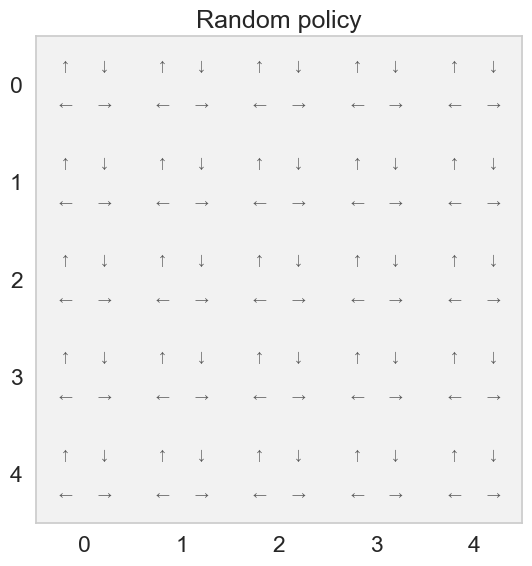

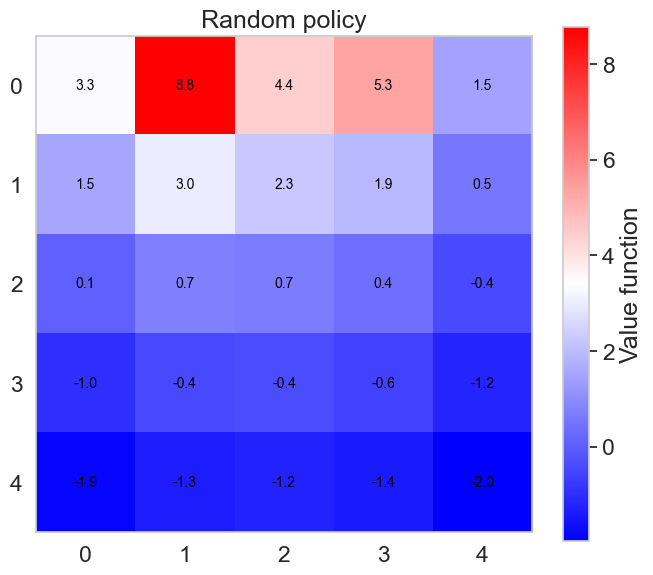

In [3]:
# Solve the linear system: (I - γP)v = r
I = np.eye(H * W)
A = I - gamma * P  # The coefficient matrix

# Direct solution using linear algebra
v_vector = np.linalg.solve(A, r)
V_explicit = v_vector.reshape(H, W)

print("Value function from EXPLICIT LINEAR SOLVE:")
print(V_explicit.round(2))

def plot_value_function(V: np.ndarray, title: str = "Value function"):
    """Plots the value function V."""
    plt.figure(figsize=(7, 6))
    plt.imshow(V, origin="upper", cmap="bwr")
    plt.colorbar(label="Value function")
    plt.title(title)

    # Overlay state values
    for r in range(H):
        for c in range(W):
            plt.text(c, r, f"{V[r, c]:.1f}", ha="center", va="center", color="black", fontsize=10)

    plt.xticks(range(W))
    plt.yticks(range(H))
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def plot_policy(policy: Policy, V: np.ndarray | None = None, title: str = "Policy"):
    """Plots a policy with action arrows.

    Args:
        policy: A Policy object to visualize
        V: Optional value function to use as background (H×W array)
        title: Title for the plot
    """
    plt.figure(figsize=(7, 6))

    # Use value function as background if provided, otherwise use zeros
    if V is not None:
        plt.imshow(V, origin="upper", cmap="bwr")
        plt.colorbar(label="Value function")
    else:
        plt.imshow(np.zeros((H, W)), origin="upper", cmap="gray", vmin=-1, vmax=1, alpha=0.1)

    plt.title(title)

    # Overlay policy arrows
    for r in range(H):
        for c in range(W):
            action_probs = policy.get_action_probs((r, c))

            # If deterministic (one action has prob ≈ 1), show single arrow
            if np.max(action_probs) > 0.99:
                action_idx = int(np.argmax(action_probs))
                plt.text(c, r, A_NAMES[action_idx],
                        ha="center", va="center", color="black",
                        fontsize=16, fontweight="bold")
            else:
                # Stochastic: show all arrows in corners
                offsets = [(-0.2, -0.2), (0.2, -0.2), (-0.2, 0.2), (0.2, 0.2)]
                for a_idx, (ox, oy) in enumerate(offsets):
                    prob = action_probs[a_idx]
                    if prob > 0.01:
                        plt.text(c + ox, r + oy, A_NAMES[a_idx],
                                ha="center", va="center", color="black",
                                fontsize=10, alpha=0.5 + 0.5 * prob)

    plt.xticks(range(W))
    plt.yticks(range(H))
    plt.grid(False)
    plt.tight_layout()
    plt.show()

plot_policy(random_policy, None, "Random policy")
plot_value_function(V_explicit, "Random policy")

## Solve for the Value Function Iteratively

We just solved the Bellman equation explicitly using linear algebra:
$$(\mathbf{I} - \gamma \mathbf{P})\mathbf{v} = \mathbf{r}$$
$$\mathbf{v} = (\mathbf{I} - \gamma \mathbf{P})^{-1} \mathbf{r}$$

This direct solution works great for our 5×5 gridworld (25 states), but has a major limitation,
that lays in the computational complexity $O(n^3)$ of inverting the matrix, where $n$ is the number of states.
Furthermore, it won't work for continuous state spaces.

### The Iterative Alternative

Instead of inverting the matrix, we can rearrange the equation:

$$(\mathbf{I} - \gamma \mathbf{P})\mathbf{v} = \mathbf{r}$$
$$\mathbf{v} - \gamma \mathbf{P}\mathbf{v} = \mathbf{r}$$
$$\mathbf{v} = \mathbf{r} + \gamma \mathbf{P}\mathbf{v}$$

This suggests an **iterative scheme**: Start with $\mathbf{v}_0$ (e.g., zeros), then repeatedly apply:

$$\mathbf{v}_{k+1} = \mathbf{r} + \gamma \mathbf{P}\mathbf{v}_k$$

This addresses the computational challenge by avoiding matrix inversion, 
and takes much smaller memory footprint.

### Why Does Iterative Evaluation Work?

The iterative approach is based on the **Bellman operator** being a **contraction mapping**.

Define the operator $\mathcal{B}_{\pi}$ that acts on value functions (with policy $\pi$):

$$(\mathcal{B}_{\pi} v)(s) = \sum_a \pi(a|s) \sum_{s'} p(s'|s,a) [r(s,a,s') + \gamma v(s')]$$

Or in matrix form: $\mathcal{B}_{\pi} \mathbf{v} = \mathbf{r} + \gamma \mathbf{P} \mathbf{v}$

The true value function $v_{\pi}$ is a **fixed point** of this operator:
$$\mathcal{B}_{\pi} v_{\pi} = v_{\pi}$$

This is exactly the equation $\mathbf{v} = \mathbf{r} + \gamma \mathbf{P}\mathbf{v}$ we derived from the linear system!


The iteration $\mathbf{v}_{k+1} = \mathbf{r} + \gamma \mathbf{P}\mathbf{v}_k$ is a classical **stationary iterative method** for solving $(\mathbf{I} - \gamma \mathbf{P})\mathbf{v} = \mathbf{r}$.

In addition, this iterative method will become useful when we discuss value iteration later, with Bellman optimality equation.

✓ Converged after 90 iterations
  Final delta: 9.50e-07


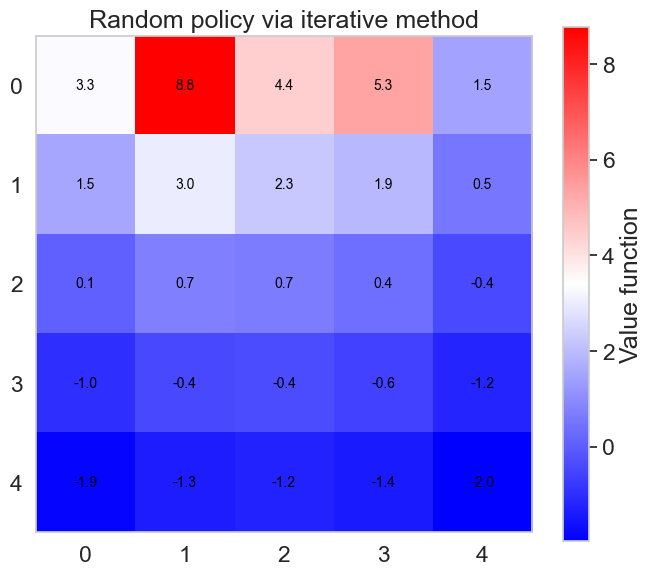

In [4]:
def policy_evaluation_iterative(policy: Policy, theta: float = 1e-6, max_iter: int = 10000):
    """Evaluates a policy using iterative Bellman updates: v_{k+1} = r + γPv_{k}.

    Args:
        policy: A Policy object to evaluate
        theta: Convergence threshold
        max_iter: Maximum number of iterations

    Returns:
        V: Value function (H by W array)
        history: List of value functions at each iteration
        deltas: List of max changes at each iteration
    """
    # Build the linear system for this policy
    P, r = build_linear_system(policy)

    # Initialize value vector
    v = np.zeros(H * W)
    history = [v.copy()]
    deltas = []

    # Iterative updates: v_{k+1} = r + γPv_k
    for k in range(max_iter):
        v_new = r + gamma * (P @ v)

        # Compute max change
        delta = np.max(np.abs(v_new - v))
        deltas.append(delta)

        # Store history
        history.append(v_new.copy())

        # Update v
        v = v_new

        # Check convergence
        if delta < theta:
            print(f"✓ Converged after {k+1} iterations")
            print(f"  Final delta: {delta:.2e}")
            break
    else:
        print(f"Reached max iterations ({max_iter})")

    # Reshape to grid
    V = v.reshape(H, W)
    history_grids = [h.reshape(H, W) for h in history]

    return V, history_grids, deltas

V_iterative, _, _ = policy_evaluation_iterative(random_policy, max_iter=100_000)
plot_value_function(V_iterative, "Random policy via iterative method")


## Improve the Policy Greedily (Policy Iteration)

We just evaluated the random policy and found its value function $v_{\pi_{random}}$. But the random policy is clearly not optimal - it doesn't use any information about which actions lead to higher rewards!

### Policy Improvement

Given a value function $v_{\pi}$ for some policy $\pi$, we can **improve** the policy by being **greedy** with respect to the values:

For each state $s$, compute the **action-value** (Q-value) for each action:
$$q_{\pi}(s,a) = \sum_{s'} p(s'|s,a) [r(s,a,s') + \gamma v_{\pi}(s')]$$

In our deterministic gridworld, this simplifies to:
$$q_{\pi}(s,a) = r(s,a,s') + \gamma v_{\pi}(s')$$

Then create a new policy $\pi'$ that selects the action(s) with maximum Q-value:
$$\pi'(s) = \arg\max_a q_{\pi}(s,a)$$

### The Policy Iteration Algorithm

Policy Improvement suggests a natural algorithm:

1. Initialize $\pi$ arbitrarily (e.g., random policy)
2. Repeat until convergence:
    - Policy Evaluation: Compute $v_{\pi}$
    - Policy Improvement: Set $\pi' = \text{greedy}(v_{\pi})$
3. If $\pi' = \pi$, stop (found optimal policy!)


This is called **Policy Iteration**, and it's guaranteed to converge to the optimal policy in a finite number of iterations!

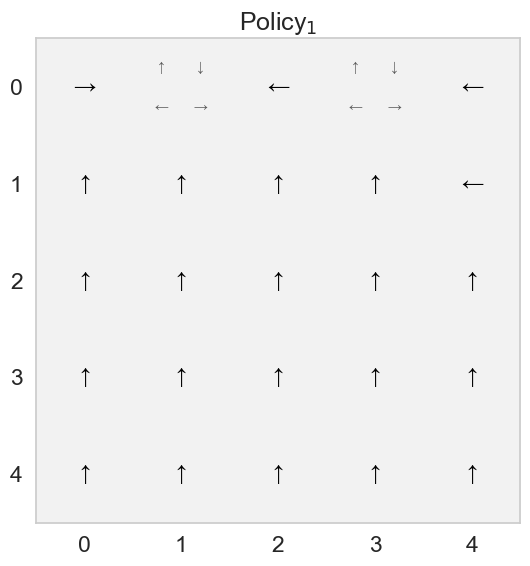

✓ Converged after 154 iterations
  Final delta: 9.98e-07


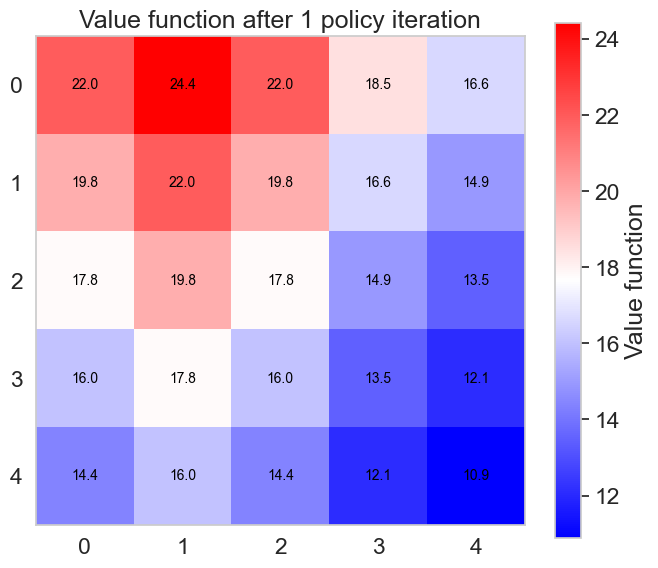

In [5]:
def policy_improvement(V: np.ndarray) -> Policy:
    """Creates a greedy policy from a value function (Policy Improvement).

    For each state, selects action(s) that maximize:
        Q(s,a) = r(s,a,s') + γ·V(s')

    When there are ties (multiple actions with same max Q-value),
    creates a stochastic policy that assigns equal probability to all tied actions.

    This is the "policy improvement" step in Policy Iteration.

    Args:
        V: Value function (H * W array)

    Returns:
        Policy object (deterministic if no ties, stochastic if ties exist)
    """
    policy_probs = np.zeros((H, W, 4))

    for r in range(H):
        for c in range(W):
            # Compute Q-values for all actions
            q_values = []
            for a in range(len(ACTIONS)):
                (next_r, next_c), reward = step((r, c), a)
                q_value = reward + gamma * V[next_r, next_c]
                q_values.append(q_value)

            # Find all actions with maximum Q-value (handle ties)
            q_values = np.array(q_values)
            max_q = np.max(q_values)
            best_actions = np.isclose(q_values, max_q)  # Boolean mask of tied actions

            # Assign equal probability to all best actions
            num_best = np.sum(best_actions)
            policy_probs[r, c, best_actions] = 1.0 / num_best

    # Create Policy object from probability distribution
    return Policy(probs=policy_probs)

V_0 = V_iterative  # Initial value function
policy_iteration_1 = policy_improvement(V_iterative)  # Policy update, get policy_1
plot_policy(policy_iteration_1, None, "Policy$_{1}$")

V_policy_1, _, _ = policy_evaluation_iterative(policy_iteration_1, max_iter=100_000)
plot_value_function(V_policy_1, "Value function after 1 policy iteration")

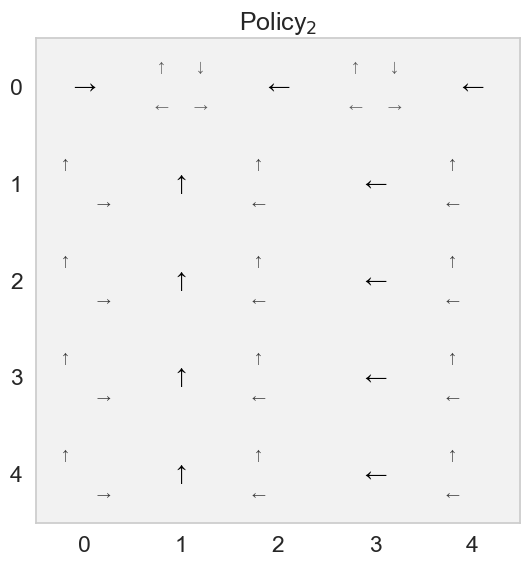

✓ Converged after 154 iterations
  Final delta: 9.98e-07


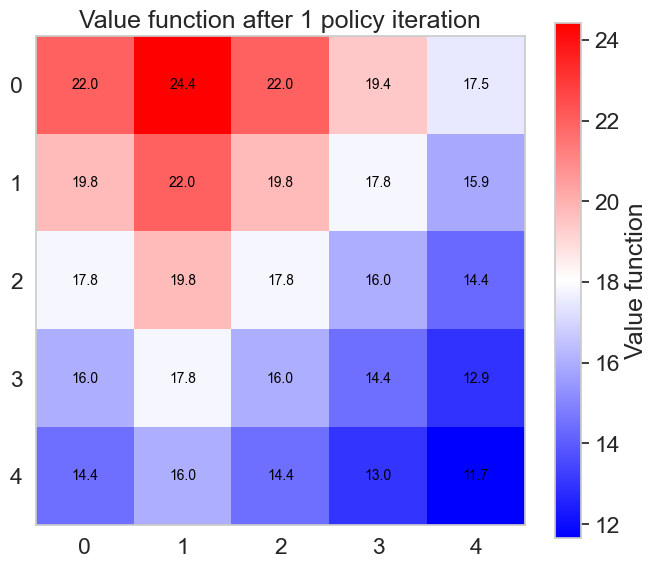

In [6]:
policy_iteration_2 = policy_improvement(V_policy_1)  # Policy update, get policy_2
plot_policy(policy_iteration_2, None, "Policy$_{2}$")

V_policy_2, _, _ = policy_evaluation_iterative(policy_iteration_2, max_iter=100_000)
plot_value_function(V_policy_2, "Value function after 1 policy iteration")

## From Policy Iteration to Value Iteration

Policy Iteration alternates between two steps:
1. **Policy Evaluation**: Solve $v_{\pi}(s) = \sum_a \pi(a|s) \sum_{s'} p(s'|s,a) [r(s,a,s') + \gamma v_{\pi}(s')]$
2. **Policy Improvement**: Update $\pi(s) = \arg\max_a q_{\pi}(s,a)$

But notice something: in policy improvement, we compute q-values and take the max. What if we **fused** these two steps into one?

### The Bellman Optimality Equation

Instead of evaluating a *specific* policy, we can directly ask: "What is the value of being in state $s$ if we act *optimally* from now on?"

This is captured by the **Bellman Optimality Equation**:

$$ v_{*}(s) = \max_a \sum_{s'} p(s'|s,a) [ r(s,a,s') + \gamma v_{*}(s') ] $$

**Key difference from the regular Bellman equation:**
- Regular Bellman: $\sum_a \pi(a|s) [...]$ — averages over a fixed policy's actions
- Bellman Optimality: $\max_a [...]$ — selects the best action

The function $v_{*}(s)$ represents the **optimal value**: the best possible expected return from state $s$.

Once we have $v_{*}$, we can extract an optimal policy by being greedy:

$$ \pi_{*}(s) = \arg\max_a \sum_{s'} p(s'|s,a) [ r(s,a,s') + \gamma v_{*}(s') ] $$

### Value Iteration: Iterating the Bellman Optimality Equation

Here's the key insight: just like we iterated the regular Bellman equation to evaluate a policy, we can **iterate the Bellman Optimality equation** to find $v_{*}$!

**Value Iteration Algorithm:**

1. Initialize $v_0(s)$ arbitrarily (e.g., zeros)
2. Repeat until convergence:
   $$v_{k+1}(s) \leftarrow \max_a \sum_{s'} p(s'|s,a) [ r(s,a,s') + \gamma v_k(s') ]$$
3. Extract the greedy policy: 
   $$\pi(s) = \arg\max_a \sum_{s'} p(s'|s,a) [ r(s,a,s') + \gamma v(s') ]$$

**Notice:** Step 2 is literally just applying the Bellman optimality equation! The $\max$ operator implicitly does policy improvement at every iteration.

### Comparison: Policy Iteration vs. Value Iteration

| Aspect | Policy Iteration | Value Iteration |
|--------|-----------------|-----------------|
| **Updates** | $v_{\pi}(s) = \sum_a \pi(a\|s) [...]$ | $v(s) \leftarrow \max_a [...]$ |
| **Explicit Policy?** | Yes, maintain $\pi$ | No, implicit in $\max$ |
| **Steps per iteration** | 2 (evaluate + improve) | 1 (fused together) |
| **Convergence** | Fewer iterations, more work per iteration | More iterations, less work each |

Both are guaranteed to converge to $v_{*}$ and $\pi_{*}$, but they take different paths to get there!

**Intuition:** 
- Policy Iteration: "Fully commit to a policy, evaluate it completely, then switch to a better one"
- Value Iteration: "Keep values approximate, gradually improve them with the max operator"

Let's implement value iteration and compare it with policy iteration!

✓ Value iteration converged after 154 iterations
  Final delta: 9.98e-07


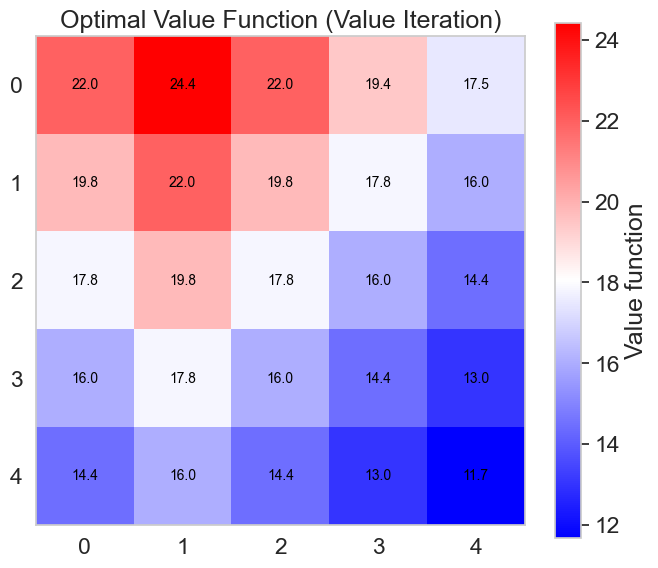

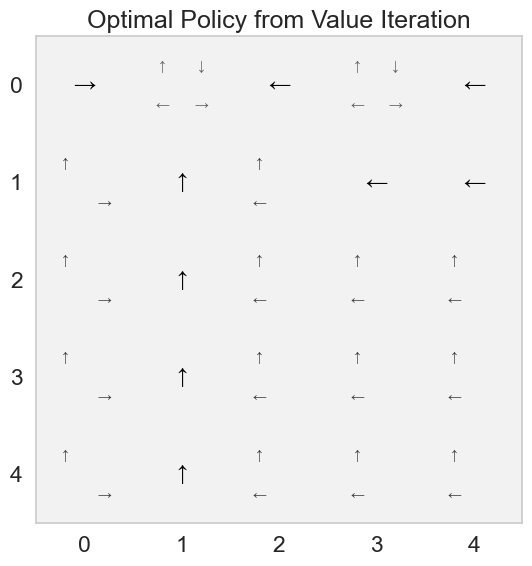

In [7]:
def value_iteration(theta: float = 1e-6, max_iter: int = 10000):
    """Runs Value Iteration to compute v_* and its greedy policy.

    Iteratively applies the Bellman optimality update until values converge:
        v_{k+1}(s) = max_a [r(s,a,s') + γ·v_k(s')]

    Then extracts a greedy policy using make_greedy_policy().

    Args:
        theta: Convergence threshold on max-norm change in v. Defaults to 1e-6.
        max_iter: Maximum number of iterations. Defaults to 10000.

    Returns:
        V: Optimal state values v_* (H×W array)
        policy: Optimal policy π_* (Policy object)
        history: List of value functions at each iteration
        deltas: List of max changes at each iteration
    """
    V = np.zeros((H, W), dtype=float)
    history = [V.copy()]
    deltas = []

    # Value updates until convergence or iteration limit
    for k in range(max_iter):
        delta = 0.0
        V_old = V.copy()

        for r in range(H):
            for c in range(W):
                # Compute q-values for all actions
                q_vals = []
                for a in range(len(ACTIONS)):
                    (next_r, next_c), reward = step((r, c), a)
                    q_vals.append(reward + gamma * V_old[next_r, next_c])

                # Bellman optimality backup: v(s) ← max_a q(s,a)
                V[r, c] = float(np.max(q_vals))
                delta = max(delta, abs(V[r, c] - V_old[r, c]))

        # Store history
        history.append(V.copy())
        deltas.append(delta)

        # Check convergence
        if delta < theta:
            print(f"✓ Value iteration converged after {k+1} iterations")
            print(f"  Final delta: {delta:.2e}")
            break
    else:
        print(f"Reached max iterations ({max_iter})")

    # Extract greedy policy from converged values (reuse existing function!)
    policy_optimal = policy_improvement(V)

    return V, policy_optimal, history, deltas

# Run value iteration
V_optimal_vi, policy_optimal_vi, _, _ = value_iteration()


# Visualize results
plot_value_function(V_optimal_vi, "Optimal Value Function (Value Iteration)")
plot_policy(policy_optimal_vi, V=None,
           title="Optimal Policy from Value Iteration")